In [1]:
%matplotlib notebook

In [2]:
# imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation
import time
from tqdm import tqdm

In [3]:
# global parameters
N_POINTS = 200
SEED_START = 100
SEED_SIZE = 5
N_TIMES = 10000
TIME_STEP = 1.0
N_STEPS = 10
DA = 1.0
DB = 0.5
f = 0.055
k = 0.062

In [4]:
# initialize starting conditions
a = np.ones((N_POINTS, N_POINTS))
b = np.zeros((N_POINTS, N_POINTS))
b[SEED_START:SEED_START+SEED_SIZE, SEED_START:SEED_START+SEED_SIZE] = 1.0
evolution = [[a,b]]

In [5]:
# calculate for each time step
with tf.Session() as sess:
    # create input and constant nodes
    kernel = tf.constant([[0.05, 0.2, 0.05], [0.2, -1, 0.2], [0.05, 0.2, 0.05]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])
    kernel_a = DA * TIME_STEP * kernel
    kernel_b = DB * TIME_STEP * kernel
    current_a = tf.placeholder(tf.float32, shape=[N_POINTS, N_POINTS])
    current_b = tf.placeholder(tf.float32, shape=[N_POINTS, N_POINTS])
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    tf.global_variables_initializer().run()
    
    # create calculation nodes
    input_a = tf.reshape(current_a, [1, N_POINTS, N_POINTS, 1])
    input_b = tf.reshape(current_b, [1, N_POINTS, N_POINTS, 1])
    diff_a = tf.nn.conv2d(tf.pad(input_a, paddings, 'REFLECT'), kernel_a, strides=[1,1,1,1], padding='VALID')
    diff_b = tf.nn.conv2d(tf.pad(input_b, paddings, 'REFLECT'), kernel_b, strides=[1,1,1,1], padding='VALID')
    react_a = TIME_STEP * (-input_a*input_b*input_b + f*(1.0 - input_a))
    react_b = TIME_STEP * (input_a*input_b*input_b - (k+f)*input_b)
    next_a = input_a + diff_a + react_a
    next_b = input_b + diff_b + react_b
    next_a = tf.reshape(next_a, [N_POINTS, N_POINTS])
    next_b = tf.reshape(next_b, [N_POINTS, N_POINTS])

    # calculate for each time step
    for i in tqdm(range(N_TIMES)):
        feed_dict = {current_a: a, current_b: b}
        new_a, new_b = sess.run([next_a, next_b], feed_dict=feed_dict)

        if (i+1)%N_STEPS==0:
            evolution.append([new_a, new_b])
        a = new_a
        b = new_b

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.67it/s]


In [6]:
# cast evolution to a numpy array
data = np.array(evolution)
a_list = data[:,0,:,:]
b_list = data[:,1,:,:]
np.max(b_list[-1,:,:])

0.4193745255470276

<IPython.core.display.Javascript object>


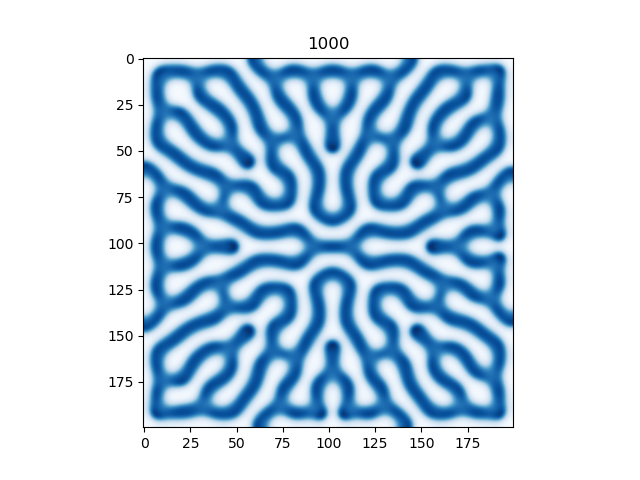

In [7]:
def make_binary(image):
    return np.where(image < 0.2, 0.0, 1.0)

def normalize(image):
    return image / image.max()

fig = plt.figure()
ax = fig.gca()


im = normalize(b_list[0,:,:])
image = plt.imshow(im, animated=True, interpolation='bilinear', cmap='Blues')

def function_for_animation(frame_index):
    im = normalize(b_list[frame_index,:,:])
    image.set_data(im)
    ax.set_title(str(frame_index))
    return image,

ani = matplotlib.animation.FuncAnimation(fig, function_for_animation, interval=10, frames=1001, repeat=False)